In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, MaxPooling1D, Concatenate, Add

Using TensorFlow backend.


In [2]:
# Building cosine wave dataset

x = 0.1*np.arange(1000)
data = np.sin(x)

In [3]:
# Scaling down the raw data with StandardScaler()

scaler_01 = StandardScaler()
data_scaled = scaler_01.fit_transform(data.reshape(-1,1))
scaler_02 = StandardScaler()
x_scaled = scaler_02.fit_transform(x.reshape(-1,1))

In [4]:

data_scaled = data_scaled.flatten()
x_scaled = x_scaled.flatten()

In [5]:

# Splitting the scaled data into training dataset

training_dataset = data_scaled[:-150]
x_training_dataset = x_scaled[:-150]

In [6]:

# Splitting the scaled data into test dataset, this dataset won't be used in LSTM model training

test_dataset = data_scaled[-(150+10):]
x_test_dataset = x_scaled[-(150+10):]

In [7]:
# Preparing the training dataset for LSTM input1 

T = 20
X = []
Y = []

for t in range(len(training_dataset)-T):
  x = training_dataset[t:t+T]
  X.append(x)
  y = training_dataset[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.Shape:",X.shape, "Y.Shape:", Y.shape)

X.Shape: (830, 20, 1) Y.Shape: (830,)


In [8]:
# Preparing the training dataset for LSTM input2 

T = 20
XX = []

for t in range(len(x_training_dataset)-T):
  x = x_training_dataset[t:t+T]
  XX.append(x)
  y = x_training_dataset[t+T]
XX = np.array(XX).reshape(-1, T, 1)
print("XX.Shape:",XX.shape)

XX.Shape: (830, 20, 1)


In [9]:
# Splitting training dataset for input1 again into x_train, x_test, y_train, y_test

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
print("x_train.shape:",x_train.shape, "x_test.shape:",x_test.shape, "y_train.shape:",y_train.shape, "y_test.shape:",y_test.shape)

x_train.shape: (664, 20, 1) x_test.shape: (166, 20, 1) y_train.shape: (664,) y_test.shape: (166,)


In [10]:
# Splitting training dataset for input2 again into xx_train, xx_test

xx_train, xx_test = train_test_split(XX, test_size=0.2, shuffle=False)
print("xx_train.shape:",xx_train.shape, "xx_test.shape:",xx_test.shape)

xx_train.shape: (664, 20, 1) xx_test.shape: (166, 20, 1)


In [11]:
# Building Double input Double layer CNN+LSTM model

input1 = Input(shape=(20,1))
x10 = Conv1D(filters=100, kernel_size=2, activation='relu')(input1)
x101 = Conv1D(filters=20, kernel_size=2, activation='relu')(x10)
x11 = MaxPooling1D(pool_size=2)(x101)
x12 = Flatten()(x11)
x1 = Dense(20, activation='relu')(x12)

input2 = Input(shape=(20,1))
x21 = LSTM(30, activation='selu', return_sequences=True)(input2)
x2 = LSTM(5, activation='selu', return_sequences=False)(x21)


# equivalent to `added = tf.keras.layers.add([x1, x2])`

added = Concatenate(axis=-1)([x1, x2])
out = Dense(1, activation='selu')(added)
model = Model(inputs=[input1, input2], outputs=out)

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])


W0730 15:06:26.166620 17284 deprecation_wrapper.py:119] From C:\Users\22458147\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 15:06:26.286301 17284 deprecation.py:323] From C:\Users\22458147\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3313: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 100)      300         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 18, 20)       4020        conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 9, 20)        0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [13]:
r = model.fit([x_train.reshape(664, 20, 1), xx_train.reshape(664, 20, 1)], y_train, epochs=20, validation_data=([x_test.reshape(166, 20, 1),xx_test.reshape(166, 20, 1)], y_test))

W0730 15:06:30.915397 17284 deprecation_wrapper.py:119] From C:\Users\22458147\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 664 samples, validate on 166 samples
Epoch 1/20
664/664 [==============================] - 3s 4ms/step - loss: 0.4722 - accuracy: 0.0000e+00 - val_loss: 0.0959 - val_accuracy: 0.0000e+00
Epoch 2/20
664/664 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.0000e+00 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 3/20
664/664 [==============================] - 1s 2ms/step - loss: 0.0417 - accuracy: 0.0000e+00 - val_loss: 0.0257 - val_accuracy: 0.0000e+00
Epoch 4/20
664/664 [==============================] - 1s 2ms/step - loss: 0.0264 - accuracy: 0.0000e+00 - val_loss: 0.0236 - val_accuracy: 0.0000e+00
Epoch 5/20
664/664 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 6/20
664/664 [==============================] - 1s 2ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.0343 - val_accuracy: 0.0000e+00
Epoch 7/20
664/664 [==============================] - 

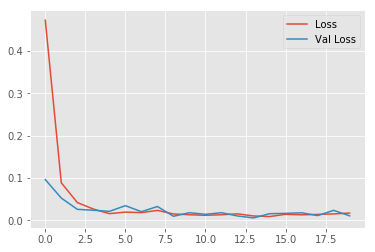

In [14]:

plt.style.use('ggplot')
plt.plot(r.history['loss'], label="Loss")
plt.plot(r.history['val_loss'], label="Val Loss")
plt.legend()
plt.show()
plt.rcParams['figure.figsize'] = 6,4

In [15]:
result = model.predict([x_test,xx_test])

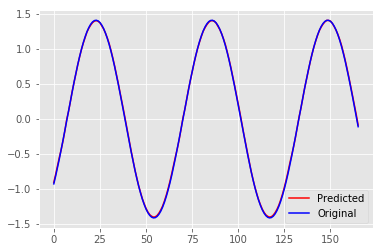

In [16]:
# Plotting y_test and predicted y_test 

plt.style.use('ggplot')
plt.plot(result, c='r', label="Predicted")
plt.plot(y_test, c='b', label="Original")
plt.legend(loc ="lower right") 
plt.show()

In [17]:
# Splitting the scaled data into test dataset, this dataset won't be used in LSTM model training

test_dataset = data_scaled[-(150+20):]
x_test_dataset = x_scaled[-(150+20):]

In [18]:
# Preparing the training dataset for LSTM input 

T = 20
X_test = []
Y_test = []

for t in range(len(test_dataset)-T):
  x = test_dataset[t:t+T]
  X_test.append(x)
  y = test_dataset[t+T]
  Y_test.append(y)
X_test = np.array(X_test).reshape(-1, T, 1)
Y_test = np.array(Y_test)
print("X_test.Shape:",X_test.shape, "Y_test.Shape:", Y_test.shape)

X_test.Shape: (150, 20, 1) Y_test.Shape: (150,)


In [19]:
# Preparing the training dataset for LSTM input 

T = 20
XX_test = []

for t in range(len(x_test_dataset)-T):
  x = x_test_dataset[t:t+T]
  XX_test.append(x)
  y = x_test_dataset[t+T]
XX_test = np.array(XX_test).reshape(-1, T, 1)
print("XX_test.Shape:",XX_test.shape)

XX_test.Shape: (150, 20, 1)


In [20]:
result_01 = model.predict([X_test,XX_test])

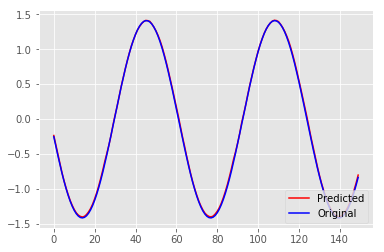

In [21]:
# Plotting y_test and predicted y_test 

plt.style.use('ggplot')
plt.plot(result_01, c='r', label="Predicted")
plt.plot(Y_test, c='b', label="Original")
plt.legend(loc ="lower right") 
plt.show()

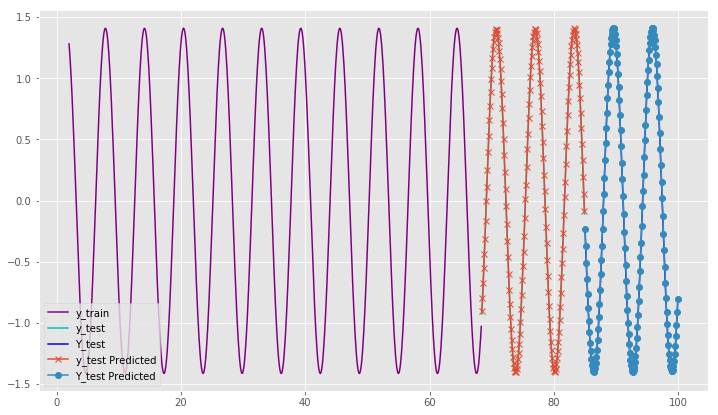

In [23]:
# Plotting y_train, y_test, Y_test, predicted y_test and predicted Y_test (with scaled values)


x = 0.1*np.arange(1000)
fig, ax1 = plt.subplots()


ax1.plot(x[20:-150][:664], y_train, c='purple', label='y_train')
ax1.plot(x[20:-150][664:], y_test, 'c-', label='y_test')
ax1.plot(x[850:], Y_test, 'b-', label='Y_test')
ax1.plot(x[20:-150][664:], result, 'x-', label='y_test Predicted')
ax1.plot(x[850:], result_01, 'o-', label='Y_test Predicted')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.legend(loc='lower left')

plt.rcParams['figure.figsize'] = 12,7
plt.show()

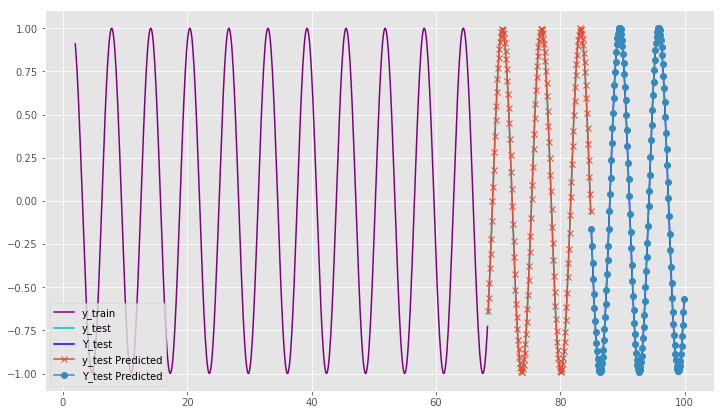

In [24]:
# Plotting y_train, predicted y_test and predicted Y_test (with original values)


fig, ax1 = plt.subplots()
ax1.plot(x[20:-150][:664], scaler_01.inverse_transform(y_train.reshape(-1,1)).flatten(), c='purple', label='y_train')
ax1.plot(x[20:-150][664:], scaler_01.inverse_transform(y_test.reshape(-1,1)).flatten(), 'c-', label='y_test')
ax1.plot(x[850:], scaler_01.inverse_transform(Y_test.reshape(-1,1)).flatten(), 'b-', label='Y_test')
ax1.plot(x[20:-150][664:], scaler_01.inverse_transform(result.reshape(-1,1)).flatten(), 'x-', label='y_test Predicted')
ax1.plot(x[850:], scaler_01.inverse_transform(result_01.reshape(-1,1)).flatten(), 'o-', label='Y_test Predicted')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.legend(loc='lower left')
plt.show()
plt.rcParams['figure.figsize'] = 12,7